Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

- Runs on CPU or GPU (if available)

# Convolutional GAN with Label Smoothing

Here, the label smoothing approach is to replace real image labels (1's) by 0.9, based on the idea in

- Salimans, Tim, Ian Goodfellow, Wojciech Zaremba, Vicki Cheung, Alec Radford, and Xi Chen. "Improved techniques for training GANs." In Advances in Neural Information Processing Systems, pp. 2234-2242. 2016.

## Imports

In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Loss function

![](./images/gans/loss.png)

一切损失计算都是在D（判别器）输出处产生的，而D的输出一般是fake/true的判断，所以整体上采用的是二进制交叉熵函数。

　　左边包含两部分minG和maxD。

　　首先看一下maxD部分，因为训练一般是先保持G（生成器）不变训练D的。D的训练目标是正确区分fake/true，如果我们以1/0代表true/fake，则对第一项E因为输入采样自真实数据所以我们期望D(x)趋近于1，也就是第一项更大。同理第二项E输入采样自G生成数据，所以我们期望D(G(z))趋近于0更好，也就是说第二项又是更大。所以是这一部分是期望训练使得整体更大了，也就是maxD的含义了。

　　第二部分保持D不变，训练G，这个时候只有第二项E有用了，关键来了，因为我们要迷惑D，所以这时将label设置为1(我们知道是fake，所以才叫迷惑)，希望D(G(z))输出接近于1更好，也就是这一项越小越好，这就是minG。当然判别器哪有这么好糊弄，所以这个时候判别器就会产生比较大的误差，误差会更新G，那么G就会变得更好了，这次没有骗过你，只能下次更努力了。

　　大概就是这样一个博弈过程了。自娱自乐，高手刷到请略过。

In [10]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
generator_learning_rate = 0.0001
discriminator_learning_rate = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 128
LATENT_DIM = 100
IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 1
for x in IMG_SHAPE:
    IMG_SIZE *= x



##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class Reshape(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), 64,7,7) # 64 * 7 * 7 = 3136

In [12]:
Generator = nn.Sequential(
    nn.Linear(LATENT_DIM, 3136, bias=False),
    nn.BatchNorm1d(num_features=3136),
    nn.LeakyReLU(inplace=True, negative_slope=0.0001),
    Reshape(),

    nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
    nn.BatchNorm2d(num_features=32),
    nn.LeakyReLU(inplace=True, negative_slope=0.0001),

    nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
    nn.BatchNorm2d(num_features=16),
    nn.LeakyReLU(inplace=True, negative_slope=0.0001),

    nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=0, bias=False),
    nn.BatchNorm2d(num_features=8),
    nn.LeakyReLU(inplace=True, negative_slope=0.0001),

    nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=(2, 2), stride=(1, 1), padding=0, bias=False),
    nn.Tanh()
)

Discriminator = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=8, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
    nn.BatchNorm2d(num_features=8),
    nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
        #nn.Dropout2d(p=0.2),

    nn.Conv2d(in_channels=8, out_channels=32, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
    nn.BatchNorm2d(num_features=32),
    nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
        #nn.Dropout2d(p=0.2),
    Flatten(),
    nn.Linear(7*7*32, 1)
)

Generator.to(device)
Discriminator.to(device)

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.0001, inplace=True)
  (3): Conv2d(8, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.0001, inplace=True)
  (6): Flatten()
  (7): Linear(in_features=1568, out_features=1, bias=True)
)

In [13]:
from torchsummary import summary

In [14]:
summary(Discriminator, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 14, 14]              72
       BatchNorm2d-2            [-1, 8, 14, 14]              16
         LeakyReLU-3            [-1, 8, 14, 14]               0
            Conv2d-4             [-1, 32, 7, 7]           2,304
       BatchNorm2d-5             [-1, 32, 7, 7]              64
         LeakyReLU-6             [-1, 32, 7, 7]               0
           Flatten-7                 [-1, 1568]               0
            Linear-8                    [-1, 1]           1,569
Total params: 4,025
Trainable params: 4,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.02
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [15]:
summary(Generator,(100,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3136]         313,600
       BatchNorm1d-2                 [-1, 3136]           6,272
         LeakyReLU-3                 [-1, 3136]               0
           Reshape-4             [-1, 64, 7, 7]               0
   ConvTranspose2d-5           [-1, 32, 13, 13]          18,432
       BatchNorm2d-6           [-1, 32, 13, 13]              64
         LeakyReLU-7           [-1, 32, 13, 13]               0
   ConvTranspose2d-8           [-1, 16, 25, 25]           4,608
       BatchNorm2d-9           [-1, 16, 25, 25]              32
        LeakyReLU-10           [-1, 16, 25, 25]               0
  ConvTranspose2d-11            [-1, 8, 27, 27]           1,152
      BatchNorm2d-12            [-1, 8, 27, 27]              16
        LeakyReLU-13            [-1, 8, 27, 27]               0
  ConvTranspose2d-14            [-1, 1,

In [16]:
optim_gener = torch.optim.Adam(Generator.parameters(), lr=generator_learning_rate)
optim_discr = torch.optim.Adam(Discriminator.parameters(), lr=discriminator_learning_rate)

In [18]:
test_sample = next(iter(train_loader))
len(test_sample)
test_sample[0].shape, test_sample[1]

(torch.Size([128, 1, 28, 28]),
 tensor([8, 1, 0, 7, 9, 8, 0, 2, 4, 7, 4, 5, 8, 7, 1, 4, 8, 3, 1, 1, 3, 8, 5, 1,
         8, 3, 6, 0, 4, 2, 4, 6, 5, 2, 1, 3, 4, 7, 0, 1, 0, 3, 1, 4, 6, 4, 9, 8,
         0, 2, 9, 3, 6, 2, 4, 0, 3, 9, 1, 3, 0, 8, 6, 2, 2, 4, 3, 8, 0, 7, 2, 4,
         1, 0, 4, 3, 6, 8, 8, 5, 9, 5, 3, 6, 0, 6, 9, 2, 1, 1, 2, 4, 9, 4, 0, 2,
         0, 8, 1, 5, 0, 9, 2, 7, 8, 2, 4, 3, 4, 9, 0, 3, 4, 6, 1, 4, 6, 0, 0, 8,
         0, 7, 1, 9, 8, 6, 2, 2]))

In [23]:
start_time = time.time()    

discr_costs = []
gener_costs = []

for epoch in range(NUM_EPOCHS):
    Generator.train()
    Discriminator.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = (features - 0.5) * 2
        features = features.view(-1, IMG_SIZE).to(device)
        
        targets = targets.to(device)
        
        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).to(device)
        
        # --------------------------
        # Train Generator
        # --------------------------
    
        # Make new images
        z = torch.zeros((targets.size(0)), LATENT_DIM).uniform_(-1.0,1.0).to(device)
        generated_features = Generator(z)

        # Loss for fooling the discriminator
        discr_pred = Discriminator(generated_features.view(targets.size(0), 1, 28, 28))
        gener_loss = F.binary_cross_entropy_with_logits(discr_pred.view(-1), valid*0.9)

        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()

        # --------------------------
        # Train Discriminator
        # --------------------------   
        discr_pred_real = Discriminator(features.view(targets.size(0), 1, 28, 28)) 
        real_loss = F.binary_cross_entropy_with_logits(discr_pred_real.view(-1), valid*0.9)

        discr_pred_fake = Discriminator(generated_features.view(targets.size(0), 1, 28, 28).detach())
        fake_loss = F.binary_cross_entropy_with_logits(discr_pred_fake.view(-1), fake)

        discr_loss = 0.5*(real_loss + fake_loss)
        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()        

        discr_costs.append(discr_loss.item())
        gener_costs.append(gener_loss.item())
    
        ### LOGGING
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), gener_loss, discr_loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Batch 000/469 | Gen/Dis Loss: 0.6003/0.7569
Epoch: 001/100 | Batch 100/469 | Gen/Dis Loss: 1.4101/0.3494
Epoch: 001/100 | Batch 200/469 | Gen/Dis Loss: 2.0660/0.2473
Epoch: 001/100 | Batch 300/469 | Gen/Dis Loss: 2.3694/0.2196
Epoch: 001/100 | Batch 400/469 | Gen/Dis Loss: 2.6368/0.2104
Time elapsed: 0.21 min
Epoch: 002/100 | Batch 000/469 | Gen/Dis Loss: 2.4973/0.2127
Epoch: 002/100 | Batch 100/469 | Gen/Dis Loss: 2.7234/0.1967
Epoch: 002/100 | Batch 200/469 | Gen/Dis Loss: 1.6751/0.3124
Epoch: 002/100 | Batch 300/469 | Gen/Dis Loss: 1.4935/0.3456
Epoch: 002/100 | Batch 400/469 | Gen/Dis Loss: 1.5921/0.3236
Time elapsed: 0.41 min
Epoch: 003/100 | Batch 000/469 | Gen/Dis Loss: 1.3337/0.3937
Epoch: 003/100 | Batch 100/469 | Gen/Dis Loss: 1.3450/0.4234
Epoch: 003/100 | Batch 200/469 | Gen/Dis Loss: 1.3610/0.4025
Epoch: 003/100 | Batch 300/469 | Gen/Dis Loss: 1.2330/0.4412
Epoch: 003/100 | Batch 400/469 | Gen/Dis Loss: 1.2649/0.4632
Time elapsed: 0.62 min
Epoch: 004/100 |

Epoch: 026/100 | Batch 000/469 | Gen/Dis Loss: 1.1634/0.5866
Epoch: 026/100 | Batch 100/469 | Gen/Dis Loss: 0.9736/0.6098
Epoch: 026/100 | Batch 200/469 | Gen/Dis Loss: 1.1434/0.5574
Epoch: 026/100 | Batch 300/469 | Gen/Dis Loss: 1.2435/0.5231
Epoch: 026/100 | Batch 400/469 | Gen/Dis Loss: 1.0833/0.5504
Time elapsed: 5.35 min
Epoch: 027/100 | Batch 000/469 | Gen/Dis Loss: 1.0937/0.5295
Epoch: 027/100 | Batch 100/469 | Gen/Dis Loss: 1.1162/0.5422
Epoch: 027/100 | Batch 200/469 | Gen/Dis Loss: 1.0878/0.6176
Epoch: 027/100 | Batch 300/469 | Gen/Dis Loss: 1.1133/0.5625
Epoch: 027/100 | Batch 400/469 | Gen/Dis Loss: 1.1529/0.5488
Time elapsed: 5.55 min
Epoch: 028/100 | Batch 000/469 | Gen/Dis Loss: 0.9808/0.5714
Epoch: 028/100 | Batch 100/469 | Gen/Dis Loss: 1.0456/0.6034
Epoch: 028/100 | Batch 200/469 | Gen/Dis Loss: 1.0469/0.5708
Epoch: 028/100 | Batch 300/469 | Gen/Dis Loss: 1.0324/0.5546
Epoch: 028/100 | Batch 400/469 | Gen/Dis Loss: 1.1496/0.5644
Time elapsed: 5.76 min
Epoch: 029/100 |

Epoch: 051/100 | Batch 000/469 | Gen/Dis Loss: 0.9147/0.6117
Epoch: 051/100 | Batch 100/469 | Gen/Dis Loss: 0.9388/0.6502
Epoch: 051/100 | Batch 200/469 | Gen/Dis Loss: 0.9175/0.6363
Epoch: 051/100 | Batch 300/469 | Gen/Dis Loss: 0.9665/0.6262
Epoch: 051/100 | Batch 400/469 | Gen/Dis Loss: 0.9625/0.6305
Time elapsed: 10.49 min
Epoch: 052/100 | Batch 000/469 | Gen/Dis Loss: 0.9687/0.6391
Epoch: 052/100 | Batch 100/469 | Gen/Dis Loss: 0.8787/0.6266
Epoch: 052/100 | Batch 200/469 | Gen/Dis Loss: 0.8824/0.6481
Epoch: 052/100 | Batch 300/469 | Gen/Dis Loss: 0.9516/0.6076
Epoch: 052/100 | Batch 400/469 | Gen/Dis Loss: 0.8972/0.6545
Time elapsed: 10.70 min
Epoch: 053/100 | Batch 000/469 | Gen/Dis Loss: 0.9588/0.6258
Epoch: 053/100 | Batch 100/469 | Gen/Dis Loss: 0.9411/0.6334
Epoch: 053/100 | Batch 200/469 | Gen/Dis Loss: 1.0232/0.5806
Epoch: 053/100 | Batch 300/469 | Gen/Dis Loss: 0.9261/0.6148
Epoch: 053/100 | Batch 400/469 | Gen/Dis Loss: 0.9294/0.6454
Time elapsed: 10.90 min
Epoch: 054/10

Time elapsed: 15.43 min
Epoch: 076/100 | Batch 000/469 | Gen/Dis Loss: 0.9368/0.6455
Epoch: 076/100 | Batch 100/469 | Gen/Dis Loss: 0.8239/0.6752
Epoch: 076/100 | Batch 200/469 | Gen/Dis Loss: 0.9266/0.6693
Epoch: 076/100 | Batch 300/469 | Gen/Dis Loss: 0.9151/0.6509
Epoch: 076/100 | Batch 400/469 | Gen/Dis Loss: 0.9200/0.6243
Time elapsed: 15.64 min
Epoch: 077/100 | Batch 000/469 | Gen/Dis Loss: 0.8707/0.6881
Epoch: 077/100 | Batch 100/469 | Gen/Dis Loss: 0.8157/0.6663
Epoch: 077/100 | Batch 200/469 | Gen/Dis Loss: 0.8932/0.6597
Epoch: 077/100 | Batch 300/469 | Gen/Dis Loss: 0.8822/0.6547
Epoch: 077/100 | Batch 400/469 | Gen/Dis Loss: 0.8331/0.6761
Time elapsed: 15.84 min
Epoch: 078/100 | Batch 000/469 | Gen/Dis Loss: 0.8989/0.6544
Epoch: 078/100 | Batch 100/469 | Gen/Dis Loss: 0.8809/0.6570
Epoch: 078/100 | Batch 200/469 | Gen/Dis Loss: 0.8280/0.6556
Epoch: 078/100 | Batch 300/469 | Gen/Dis Loss: 0.8331/0.6682
Epoch: 078/100 | Batch 400/469 | Gen/Dis Loss: 0.8935/0.6882
Time elapsed:

Time elapsed: 20.57 min
Total Training Time: 20.57 min


## Evaluation

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

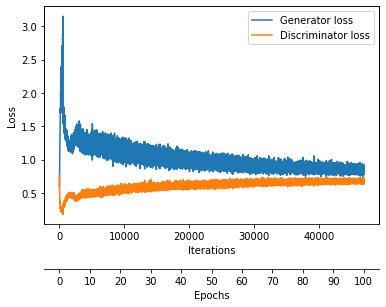

In [25]:
ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(gener_costs)), gener_costs, label='Generator loss')
ax1.plot(range(len(discr_costs)), discr_costs, label='Discriminator loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()

###################
# Set scond x-axis
ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS+1))
iter_per_epoch = len(train_loader)
newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticklabels(newlabel[::10])
ax2.set_xticks(newpos[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())
###################

plt.show()

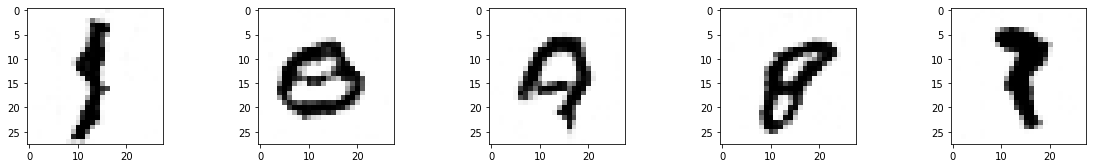

In [27]:
##########################
### VISUALIZATION
##########################


Generator.eval()
# Make new images
z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = Generator(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')